# Transformers Layers
Investigate and play with our transformer implementation, this notebook is used to investigate how the information flows on each of the transformer component, if you want to undertand more the implementation refer to the source code on the model directory.
<img src="./imgs/transformer_enc_dec.png" width="320" height="240" align="left">

#### References
* https://www.tensorflow.org/text/tutorials/transformer
* https://nlp.seas.harvard.edu/2018/04/03/attention.html#full-model
* https://theaisummer.com/self-attention/
* https://arxiv.org/pdf/2009.06732.pdf
* https://github.com/jadore801120/attention-is-all-you-need-pytorch
* https://bgg.medium.com/seq2seq-pay-attention-to-self-attention-part-2-cf81bf32c73d
* https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0
* https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
* https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
* https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463
* https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
* https://www.tensorflow.org/api_docs/python/tf/linalg/band_part

In [1]:
import sys
sys.path.append('../')
from model.sublayers.transformer import WordEmbeddings, PositionalEncoding, TransformerEncoderDecoder
from model.sublayers.transformer import scaled_dot_product_attn, MultiHeadedAttention, PositionWiseFeedForward
from model.sublayers.transformer import EncoderBlock, DecoderBlock, TransformerDecoder, TransformerEncoder
from model.sublayers.transformer import create_padding_mask, create_look_ahead_mask
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

### Input/Output Embedding
<img src="./imgs/embeddings.png" width="640" height="240" align="up">
The first step of the architecture is to convert a sequence of tokens (words, characters) with shape [batch, seq_len] to a vector dimension $d_{\text{model}}$ of shape [batch, seq_len, d_model], where $d_{model}$ will be the hidden dimension used throughout the whole architecture.

For projects involving NLP we might well use nn.Embedding or Word2Vec but other projects involving Audio, Video, or Images use other embeddings mechanisms.

In [2]:
input_sentence = torch.randint(0, 200, (1, 3))
word_emb = WordEmbeddings(d_model=4, vocab_size=200)
vector = word_emb(input_sentence)
print('Input shape:', input_sentence.shape)
print('Input data:\n', input_sentence)
print('Vector shape:', vector.shape)
print('vector data:\n', vector)

Input shape: torch.Size([1, 3])
Input data:
 tensor([[ 42, 112,  94]])
Vector shape: torch.Size([1, 3, 4])
vector data:
 tensor([[[-1.6089, -0.1581,  2.2857,  2.3629],
         [ 2.5186, -1.7263, -0.7346,  0.2470],
         [-1.9877,  0.4118,  1.3314, -2.1211]]], grad_fn=<MulBackward0>)


### Positional Encoding
<img src="./imgs/pos_encoding.png" width="640" height="240" align="up">
The transformer blocks while learning how tokens correlate to each other, it completely ignore the order of the tokens, to solve this problem the positional encoding increment into the tensors some scalar values that encode the order where the tokens appeared.

By using sin/cos functions with different frequencies we take advatnage of the different phases w.r.t to the position $pos$

$$ PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\ PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}}) $$

Input Embedding shape: torch.Size([1, 50, 20])


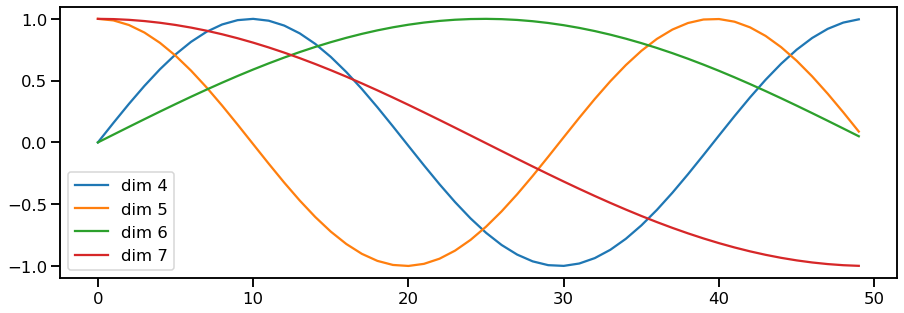

In [3]:
max_seq_len = 50
d_model=20
pe = PositionalEncoding(d_model=d_model, dropout=0, max_len=max_seq_len)

# Input embeddign without order information [batch, seq_len, d_model]
input_embedding = pe.forward(torch.zeros(1, max_seq_len, d_model))
print('Input Embedding shape:', input_embedding.shape)

# Prepare plot
plt.figure(figsize=(15, 5))
# Select first batch, all the sequence, dimensions 4 to 7
plt.plot(np.arange(max_seq_len), input_embedding[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]]);

### Scaled-Dot-Product
<img src="./imgs/Scaled_Dot-Product_Attention.png" width="320" height="240" align="right">
This operator enable the information retrieval system behaviour typical on transformers, where some query tensor will be used to search some concept encoded on the values, the key tensor is the index that allows queries to find the values.

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

It's valid to mention that the matrix multiplication between Q and K is material for a lot of other paper that try to make the memory and compute consumption non-quadratic to the sequence lenght.

In [4]:
keys = torch.rand(4, 3)
query = torch.rand(1, 3)
values = torch.rand(4, 2)
attn, attn_weights = scaled_dot_product_attn(query, keys, values)
print('Scaled dot product attention shape:', attn.shape)
print('Attention Weights shape:', attn_weights.shape)

Scaled dot product attention shape: torch.Size([1, 2])
Attention Weights shape: torch.Size([1, 4])


### Multi-Headed Attention
<img src="./imgs/MultiHeadAttn.png" width="320" height="240" align="right">
This is the module that allow the transformer to learn(which means has parameters) how each word(token) in a input prase (or any sequence) relate to each other at different positions. The multiple "heads" also gives the possibility to represent those relations in different subspaces. 

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$

In [5]:
mha = MultiHeadedAttention(num_heads=8, d_model=512)
print(mha)
# [batch_size, encoder_seq_len, d_model]
x = torch.rand(3, 60, 512)
attn, attn_weights = mha(key=x, query=x, value=x, mask=None)

# [batch_size, encoder_sequence, d_model]
print(f'Multiheaded attention output shape: {attn.shape}')

# [batch_size, num_heads, seq_len_q, seq_len_k]
print(f'Multiheaded attention weights: {attn_weights.shape}')

MultiHeadedAttention(
  (linear_q): Linear(in_features=512, out_features=512, bias=True)
  (linear_k): Linear(in_features=512, out_features=512, bias=True)
  (linear_v): Linear(in_features=512, out_features=512, bias=True)
  (linear_concat): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Multiheaded attention output shape: torch.Size([3, 60, 512])
Multiheaded attention weights: torch.Size([3, 8, 60, 60])


### Point-wise Feed Forward
<img src="./imgs/pointwise_ff.png" width="320" height="240" align="right">
Each of the transformer blocks will have a "scratch-pad" memory which is applied to each position separately and identically, it's consists of two fully-connected layers with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer.

The input/output shapes should remain the same [batch, seq_len, d_model]

The LayerNorms, like batch norm serves to make trainign less dependent of hyper-parameters, and their residual connection helps vanishing gradient issues.
<img src="./imgs/batch_vs_layer_norm.png" width="320" height="240" align="down">

The transformer architecture uses the LayerNorm also because it's more common on NLP applications but because the BatchNorm gives more difficulties to parallelize accross multiple GPUs, the authors and other people who choses to use Transformers for other applications on ther than NLP, keep using LayerNorm.

Another cool detail to pay attention is that due to the fact that the Attention will mix the sequnce and feature dimensions, the LayerNorm will actually work accross both Sequence and Feature dimensions.

In [6]:
point_wise_ff = PositionWiseFeedForward(d_model=512, d_ff=2048)
x = torch.rand(3, 60, 512)
out = point_wise_ff(x)
print(f'Point wise feed-forward shape: {out.shape}')

Point wise feed-forward shape: torch.Size([3, 60, 512])


### Transformer Encoder Block

In [7]:
encoder = EncoderBlock(d_model=512, num_heads=8, d_ff=2048)
x = torch.rand(64, 43, 512)
encoder_block_out = encoder(x)
print(f'Encoder block output shape: {out.shape}')

Encoder block output shape: torch.Size([3, 60, 512])


### Transformer Decoder Block

In [8]:
encoder = DecoderBlock(d_model=512, num_heads=8, d_ff=2048)
x = torch.rand(64, 50, 512)
decoder_block_out, _, _ = encoder(x, encoder_output=encoder_block_out, look_ahead_mask=None, padding_mask=None)
print(f'Decoder block output shape: {decoder_block_out.shape}')

Decoder block output shape: torch.Size([64, 50, 512])


### Encoder
This layer will encompass all the elements needed on the transformer encoder:
* Embedding
* Positional Encoder
* Multi-Head Self-Attention
* Point-Wise feed Forward

In [9]:
sample_encoder = TransformerEncoder(
    n_x=2, d_model=512, num_heads=8, d_ff=2048, input_vocab_size=8500, max_len=10000)

#print(sample_encoder)

# Input shape: [batch, seq_len] the input will be a batch of sequences of word indexes (integers)
input_sentence = torch.randint(0, 200, (12, 62))
encoder_out = sample_encoder(x=input_sentence, mask=None)
print(f'Encoder output shape: {encoder_out.shape}')

Encoder output shape: torch.Size([12, 62, 512])


### Decoder
This layer will encompass all the elements needed on the transformer decoder:
* Embedding (Same as encoder)
* Positional Encoder
* Multi-Head Decoder-Encoder Attention
* Multi-Head Masked Self Attention
* Point-Wise feed Forward

In [10]:
sample_decoder = TransformerDecoder(
    n_x=2, d_model=512, num_heads=8, d_ff=2048, output_vocab_size=8000, max_len=5000)

#print(sample_decoder)

# Input shape: [batch, seq_len] the input will be a batch of sequences of word indexes (integers)
previous_generated_sentences = torch.randint(0, 200, (12, 26))
decoder_out, attn_weights = sample_decoder(
    x=previous_generated_sentences, 
    encoder_output=encoder_out, 
    look_ahead_mask=None, padding_mask=None)
print(f'Decoder output shape: {decoder_out.shape}')
print(f"Decoder attention weights shape: {attn_weights['decoder_layer2_attn_weight_2'].shape}")

Decoder output shape: torch.Size([12, 26, 512])
Decoder attention weights shape: torch.Size([12, 8, 26, 62])


### Masking
The masking trick will be used on transformers to ensure the following:
* Avoid that the Decoder sees more information on the future that it allows to see
* Avoid computing on PAD tokens (tokens with value zero)

Masks shape: torch.Size([20, 20])


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

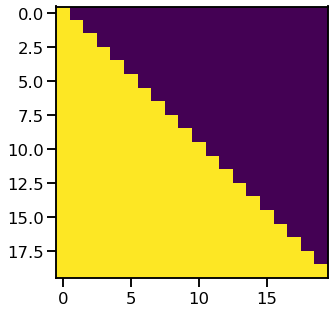

In [11]:
masks = create_look_ahead_mask(size=20)
print('Masks shape:', masks.shape)
plt.figure(figsize=(5,5))
plt.imshow(masks);

# What we can see at position 4
masks[4].numpy()

In [12]:
# Avoid PAD (zero-token)
array = np.array([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0]])
array = torch.from_numpy(array)
padding_mask = create_padding_mask(array)
print(padding_mask)

tensor([[[0, 0, 1, 1, 0]],

        [[0, 0, 0, 1, 1]]], dtype=torch.int32)


In [13]:
look_ahead = create_look_ahead_mask(size=5)
print('look_ahead.shape:', look_ahead.shape)
torch.maximum(padding_mask, look_ahead)

look_ahead.shape: torch.Size([5, 5])


tensor([[[1, 0, 1, 1, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]],

        [[1, 0, 0, 1, 1],
         [1, 1, 0, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]]], dtype=torch.int32)

### Complete Model
Now we mix all the Encoder/Decoder modules on the full architecture.

In [14]:
trf = TransformerEncoderDecoder(n_x=2, d_model=512, 
                                        num_heads=8, d_ff=2048,
                                        input_vocab_size=8500, 
                                        output_vocab_size=8000,
                                        max_len_input=10000, 
                                        max_len_output=6000)

input = torch.randint(0, 200, (64, 38))
current_output = torch.randint(0, 200, (64, 36))

# Expected shape: [batch_size, tar_seq_len, target_vocab_size]
fn_out, _ = trf(inputs=input, current_output=current_output)
print('fn_out.shape:', fn_out.shape)

fn_out.shape: torch.Size([64, 36, 8000])
